# Feature analysis using linear regression and statistical analysis

## 1) Importing modules and setting up plotting styles and paths
#### Setting plotting paramters
1.2) Set font styles.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from mendeleev import element
from itertools import chain, combinations
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline 

# Paths
cwd = os.getcwd()+'/'
datapath = cwd + 'feature_analysis_LDA/data/ORR_OH_ads.tsv'
outpath = cwd + 'feature_analysis_LDA/results/'
picpath = cwd + 'feature_analysis_LDA/pictures/'


#### Setting plotting paramters
1.2) Set font styles.

In [52]:
# Setup plotting parameters.
plt.rc('text', usetex=False)
font = {'family': 'sans-serif',
        'style': 'normal',
        'stretch': 'normal'}

plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.rc('figure')
plt.rc('lines', markeredgewidth=0, markersize=8, linewidth=1)
ticksize = 14
plt.rc('font', size=ticksize+4)
plt.rc('xtick', labelsize=ticksize+2)
plt.rc('ytick.major', size=6, width=2)
plt.rc('ytick.minor', size=6, width=2)
plt.rc('ytick', labelsize=ticksize+2)
plt.rc('ytick.major', size=6, width=2)
plt.rc('ytick.minor', size=6, width=2)

1.3) Set element-specific colors.
In order to identify the different transition metal identities in the plot, we will give every material a different color. The shape indicates the number of H atoms in the system and is therefore an indicator of the transition metal oxidation state.

Below, we define a dictionary with style for every material:
Usage: mdict[key1][key2] with
key1 = Atomic number of metal
key2 = Number of H atoms in stoichiometric unit of the LDH

In [53]:
colors=['#a6cee3','#fdbf6f','#b2df8a','#1f78b4','#e31a1c','#fb9a99','#33a02c']
tcolor='#737373'
bcolor='#252525'
symbols=['D','^','o']

mdict = {  22 : [
                ['Ti', r'$TiO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','green',symbols[2],colors[0]],
                ['Ti', r'$TiOOH-OH$',tcolor,0.0,0.08,1.5,'8','green',symbols[1],colors[0]],
                ['Ti', r'$Ti(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','green',symbols[0],colors[0]]
                ],
           23 : [
                ['V', r'$VO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','black',symbols[2],colors[1]],
                ['V', r'$VOOH-OH$',tcolor,0.0,0.08,1.5,'8','black',symbols[1],colors[1]],
                ['V', r'$V(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','black',symbols[0],colors[1]]
                ],
           24 : [
                ['Cr', r'$CrO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','yellow',symbols[2],colors[2]],
                ['Cr', r'$CrOOH-OH$', tcolor, 0.0,0.08,1.5,'8','yellow',symbols[1],colors[2]],
                ['Cr', r'$Cr(OH)_{\sf 2}-clean$', tcolor, 0.0,0.08,1.5,'8','yellow',symbols[0],colors[2]]
                ],
           25 : [
                ['Mn', r'$MnO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','darkviolet',symbols[2],colors[3]],
                ['Mn', r'$MnOOH-clean$',tcolor,0.0,0.08,1.5,'8','darkviolet',symbols[1],colors[3]],
                ['Mn', r'$Mn(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','darkviolet',symbols[0],colors[3]]
                ],
           26 : [
                ['Fe', r'$FeO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','sienna',symbols[2],colors[4]],
                ['Fe', r'$FeOOH-clean$', tcolor, 0.0,0.08,1.5,'8','sienna',symbols[1],colors[4]],
                ['Fe', r'$Fe(OH)_{\sf 2}-clean$',tcolor, 0.0,0.08,1.5,'8','sienna',symbols[0],colors[4]]
                ],
           27 : [
                ['Co', r'$CoO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','blue',symbols[2],colors[5]],
                ['Co', r'$CoOOH-clean$',tcolor,0.0,0.08,1.5,'8','blue',symbols[1],colors[5]],
                ['Co', r'$Co(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','blue',symbols[0],colors[5]]
                ],
           28 : [
                ['Ni', '$NiO_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','lime',symbols[2],colors[6]],
                ['Ni', r'$NiOOH-bridge$',bcolor,0.0,0.08,1.5,'8','lime',symbols[1],colors[6]],
                ['Ni', r'$Ni(OH)_{\sf 2}-clean$',tcolor,0.0,0.08,1.5,'8','lime',symbols[0],colors[6]]
                ]}

## 2) Data preprocessing
- Add features, select features based on collinearity 
- Normalize features

#### Read in the data and perform a first clean-up:

In [54]:
# (Re-)load and maintain the data
df = pd.read_csv(datapath, sep='\t')

# change TM names to atomic numbers
a_num = []
for row in range(0, df.shape[0]):
    atomic_name = df.iloc[row]['TM_name']
    el_id = element(atomic_name)
    atomic_number = el_id.atomic_number
    a_num.append(atomic_number)
df_l = pd.DataFrame(a_num)
df = pd.concat([df, df_l], axis=1)
df.rename(columns={list(df)[-1]:'metal_atomic_number'}, inplace=True)

# get rid of unused features
drop_list = list(df.filter(regex='OER|TM_name').columns)
df = df.drop(df[drop_list], axis=1)

# drop NA, reset index, set dtype to numeric
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df = df.astype('float64')

# add oxidation states, remove ligand numbers
df['active_site_oxidation_state'] =  df['n_d_el_atom'] - df['n_d_el_active']
df['adjacent_site_oxidation_state'] =  df['n_d_el_atom'] - df['n_d_el_adjacent'] 
df['bulk_metal_oxidation_state'] =  df['n_d_el_atom'] - df['n_d_el_bulk']
drop_list = list(df.filter(regex='nO').columns)
df = df.drop(df[drop_list], axis=1)

# rename some features
df.rename(columns={'n_d_el_atom':'Z_val_atom'}, inplace=True)
df.rename(columns={'n_d_el_bulk':'Z_val_bulk'}, inplace=True)

# # Remove first Ti = outlier
df = df.iloc[1:,:]
df = df.reset_index(drop=True)
# print(df.ORR_dG_OH.head())

# Remove bridge cases
df = df[df.bridge != 1]
df = df.reset_index(drop=True)
df = df.drop(columns = ['bridge'])

# # Remove M4+ cases
# df = df[df.bulk_metal_oxidation_state != 4.0]
# df = df.reset_index(drop=True)
# print(df.head())

#### Augment feature space by some elementary properties
We will use PyPI's Mendeleev library which contains properties of chemical elements.
For more information check out the package at: https://pypi.org/project/mendeleev/

In [55]:
# Add features from the Mendeleev library
def get_element_property(atomic_number,element_property):
    atom = element(int(atomic_number))
    prop = getattr(atom, element_property)
    return prop

new_features = ['atomic_radius',
                'c6',
                'en_pauling',
                'group_id',
                'period']

nrows = int(df.shape[0])
for i in range(0,len(new_features)):
    feature = new_features[i]
    new_values = []
    for row in range(0, nrows):
        atomic_number = int(df.iloc[row]['metal_atomic_number'])
        new_values.append(get_element_property(atomic_number,feature))
    df_l = pd.DataFrame(new_values)
    df = pd.concat([df, df_l], axis=1)
    cols = df.columns.tolist()
    cols[len(cols)-1] = str(feature)
    df.columns = cols


In [56]:
# Add ionization energies of TM to df
fpath = './linear_regression/data/ionization_energies.tsv'
io = pd.read_csv(fpath, sep='\t')
io = io.iloc[:,:]
ionnames = list(io.columns[2:])

for ionname in ionnames:
    templist = []
    zvallist = []
    for i, zval in enumerate(df.Z_val_atom):
        zvallist.append(zval)
        templist.append(io[io.Z_val_atom==zval][ionname].get_values()[0])
    df[ionname] = templist

# print(df.head())


#### Feature normalization
In order to determine the correlation between different descriptors, we normalize them using the standart scaler, which standardizes features by removing the mean and scaling to unit variance.

In [65]:
# Feature normalization and further cleanup
drop_list = list(df.filter(regex='TM|e_tot|e_form|dG').columns)
train = df.drop(df[drop_list], axis=1)
feature_names = list(train.columns)

# Feature normalization
scaler = preprocessing.StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train))
train.columns = feature_names

# Remove features with constant value
def variance_threshold_select(df, thresh=0.0, na_replacement=-999):
    df1 = df.copy(deep=True) # Make a deep copy of the dataframe
    selector = VarianceThreshold(thresh)
    selector.fit(df1.fillna(na_replacement)) # Fill NA va
    # lues as VarianceThreshold cannot deal with those
    df2 = df.loc[:,selector.get_support(indices=False)] # Get new dataframe with columns deleted that have NA values
    return(df2)

train = variance_threshold_select(train)

# We pre-identified redundant features and remove them from the feature list:
features = list(train)
redundant_features = ['metal_atomic_number', 'n_H_atoms', 'group_id']
for feature in redundant_features:
    features.remove(feature)
train = train[features]
features = list(train)
print('Features: \n'+str(features))
print('Number of features: '+str(len(features)))

Features: 
['Z_val_atom', 'Z_val_bulk', 'q_M', 'q_O', 'bandgap', 'magmom', 'd_MM', 'd_MO', 'n_d_el_active', 'n_d_el_adjacent', 'active_site_oxidation_state', 'adjacent_site_oxidation_state', 'bulk_metal_oxidation_state', 'atomic_radius', 'c6', 'en_pauling', '1st', '2nd', '3rd', '4th', '5th']
Number of features: 21


#### Final clean up and feature correlation
Automatically identify and remove redundant features and store correlation coefficients in Pearson correlation matrix.

/Users/schlexer/machine_learning/1_OXR/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


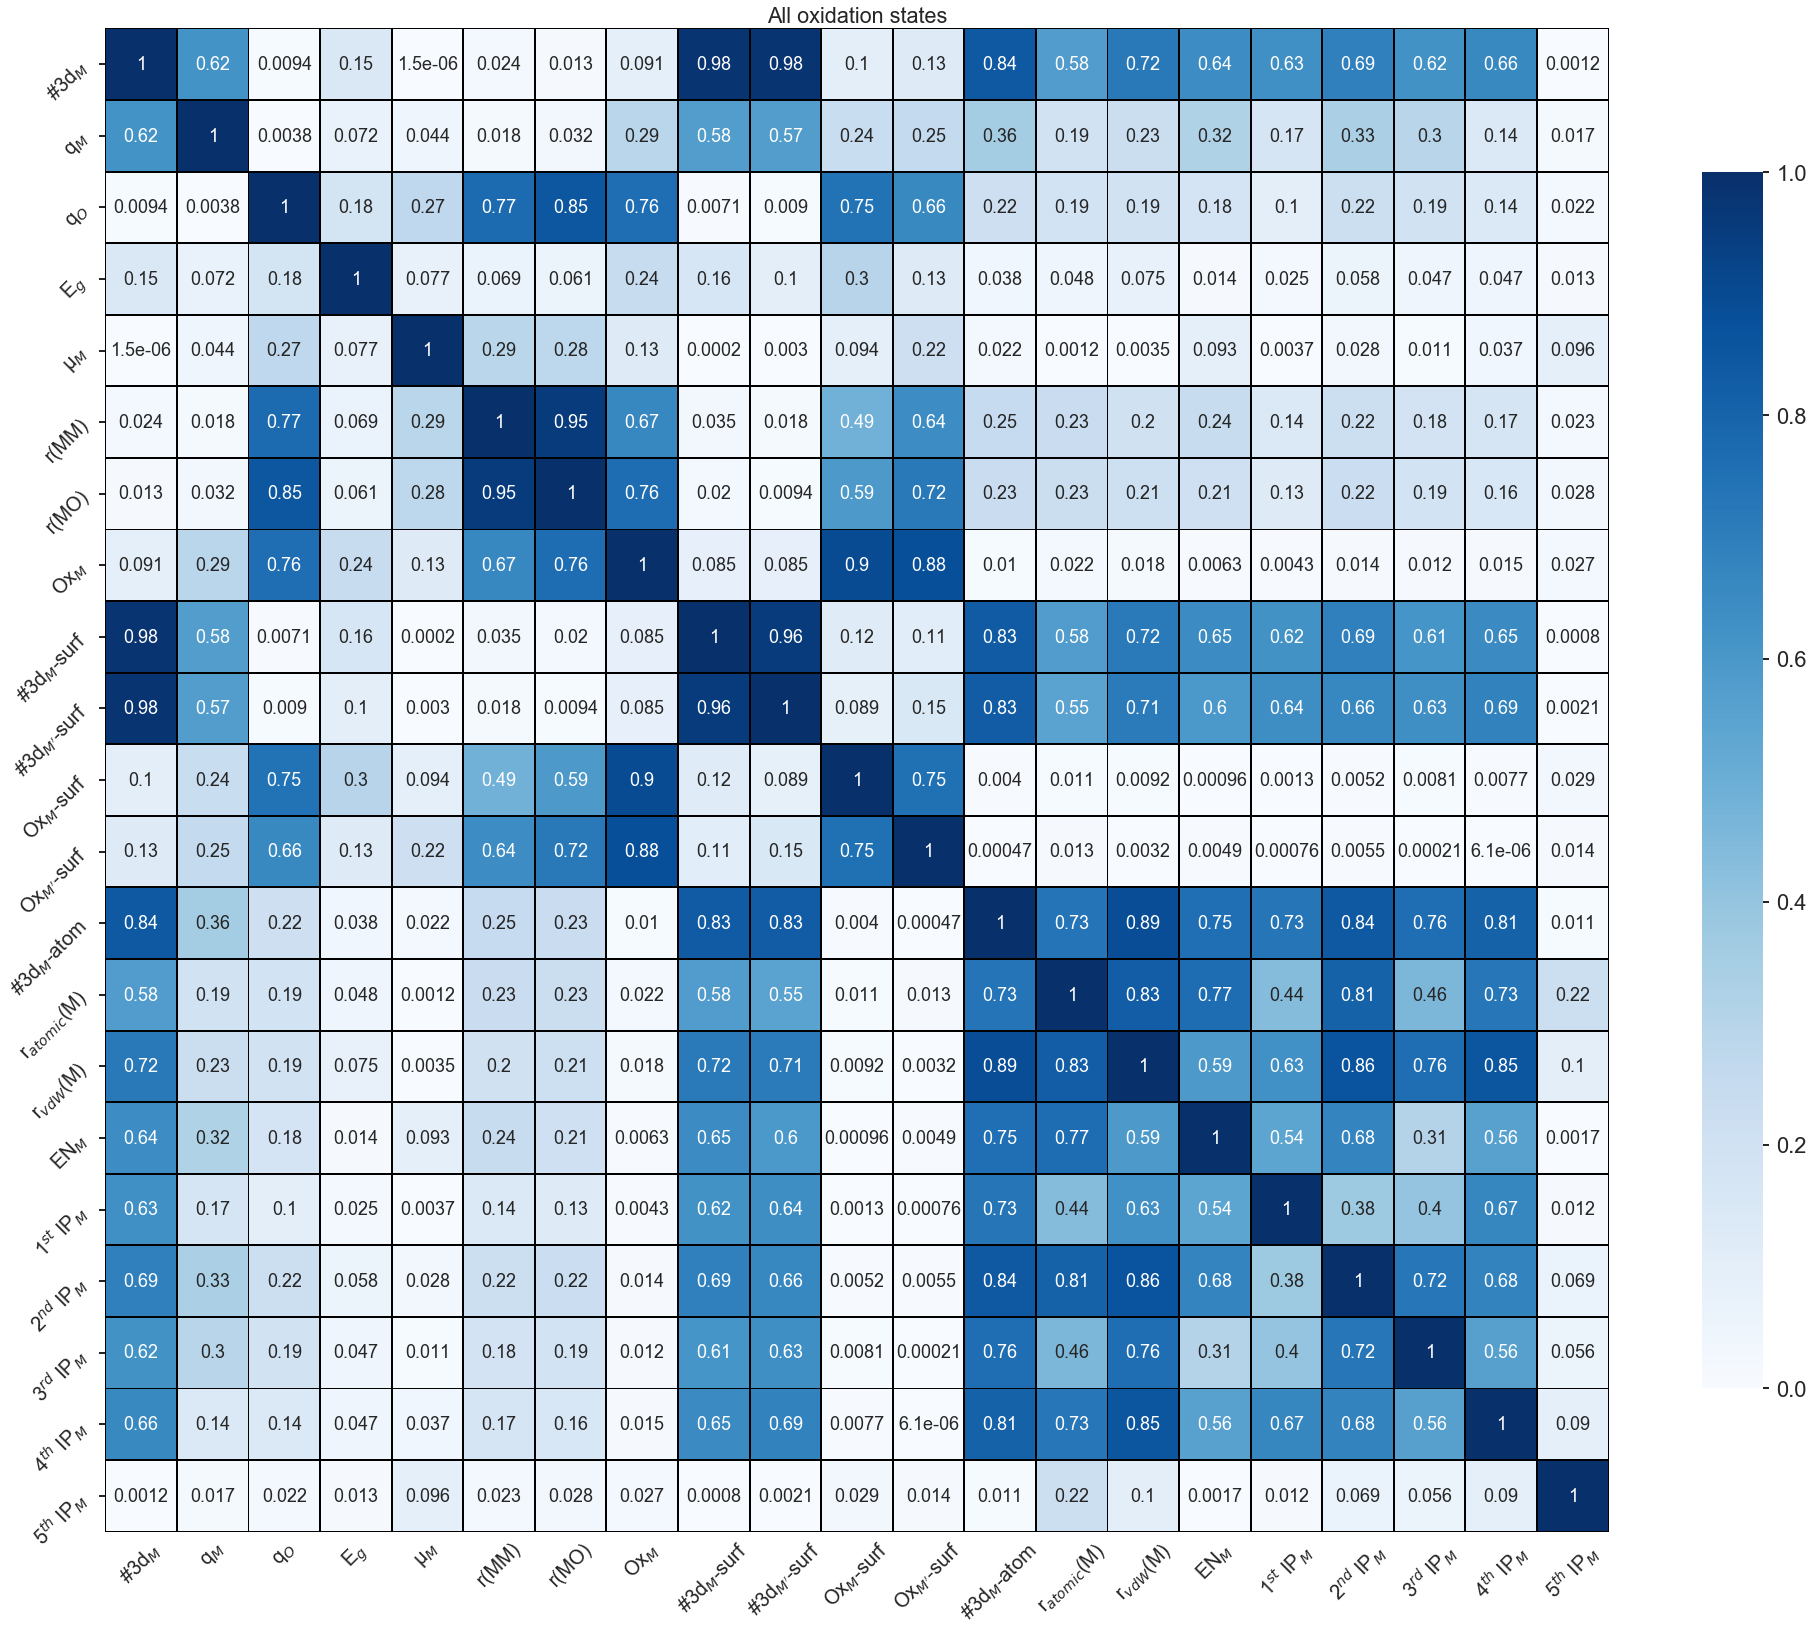

In [68]:
# Create correlation matrix of features
# Order the feature according to their nature: Atomic/Bulk/Surface
new_order = ['Z_val_bulk', 'q_M', 'q_O', 'bandgap', 'magmom',
             'd_MM', 'd_MO', 'bulk_metal_oxidation_state',
             'n_d_el_active', 'n_d_el_adjacent', 
             'active_site_oxidation_state', 'adjacent_site_oxidation_state', 
             'Z_val_atom', 'atomic_radius', 'c6', 'en_pauling']

iop =  ['1st', '2nd', '3rd', '4th', '5th']
new_order.extend(iop)

xlist = ['#3d$_{M}$', 'q$_{M}$', 'q$_{O}$', 
         'E$_{g}$', 'μ$_{M}$', 
        'r(MM)', 'r(MO)', 'Ox$_{M}$',
        '#3d$_{M}$-surf', '#3d$_{M\'}$-surf', 
        'Ox$_{M}$-surf', 'Ox$_{M\'}$-surf', 
        '#3d$_{M}$-atom', 'r$_{atomic}$(M)', 'r$_{vdW}$(M)', 
         'EN$_{M}$']

iop2 = ['1$^{st}$ IP$_{M}$', '2$^{nd}$ IP$_{M}$', 
        '3$^{rd}$ IP$_{M}$', '4$^{th}$ IP$_{M}$', '5$^{th}$ IP$_{M}$']
xlist.extend(iop2)

train = train[new_order]

# Set up correlation matrix and plot 
corr = train.corr(method='pearson')**2
pearson_corr_matrix = corr.as_matrix()
corr.columns = corr.columns.str.replace('_', ' ')
corr.index = corr.index.str.replace('_', ' ')
corr = corr.abs()


fig = plt.figure(figsize=(28, 23))
ax = sns.heatmap(corr, cmap="Blues", square=True, vmin=0, vmax=1, 
            linecolor='black', linewidths=0.9, annot=True,
             xticklabels = xlist, yticklabels=xlist, cbar_kws={"shrink": .8})

ax.tick_params(labelsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=22)

plt.tight_layout()
ax.set_title('All oxidation states')
plt.show()
fig_name = picpath + 'ORR_Pearson_correlation.pdf'                                                                                                                                                        
fig.savefig(fig_name)


In [70]:
def unique_set(iterable, feature_dim=2):
    ''' Find unique sets of n descriptors '''
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(feature_dim,feature_dim+1))


Run linear regression on each unique set of 3 descriptors.
Store the results for comparison, rank them and show the best outcomes.
Also run leave one out cross-validation (LOOCV) as further performance measure.

In [71]:
# Targets are OH adsorption energies:
target_values = list(df.filter(regex='ORR').columns)
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'
y = targets[target_name]

# Iterate over feature sets and determine feature correlations, MAE and R2
feature_dim = 3
results = []
for i, combo in enumerate(unique_set(features,feature_dim), 1):
    descriptor_combination = list(combo)
    X_combination = df[descriptor_combination]

    correlations = []
    for j, combo2 in enumerate(unique_set(descriptor_combination), 1):
        des_pairs = list(combo2)
        row = features.index(des_pairs[0])
        col = features.index(des_pairs[1])
        correlations.append(pearson_corr_matrix[row, col])
    corr_sum = sum(correlations)
    descriptor_combination.append(round(corr_sum,2))
    
    clf = linear_model.LinearRegression()
    clf.fit(X_combination, y)
    r_value = round(clf.score(X_combination, y),5)
    descriptor_combination.append(r_value)

    y_hat = clf.predict(X_combination)
    res = y_hat - y
    mae = round(np.mean(np.abs(res)),3)
    descriptor_combination.append(mae)
    
    # Cross validation
    loo = LeaveOneOut()
    ytests = []
    ypreds = []
    Xr = np.array(X_combination)
    yr = np.array(y)
    train_r_values = []
    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = Xr[train_idx], Xr[test_idx] #requires arrays
        y_train, y_test = yr[train_idx], yr[test_idx]
        
        clf.fit(X = X_train, y = y_train)
        y_pred = clf.predict(X_test)
        ytests += list(y_test)
        ypreds += list(y_pred)
        
        # Bootstrapping for R-statistics
        r_value_train = round(clf.score(X = X_train, y = y_train),5)
        train_r_values.append(r_value_train)
    
    r2_test = round(metrics.r2_score(ytests, ypreds),3)
    # mse_R_error = round(metrics.mean_squared_error(ytests, ypreds),3)
    
    mean_r_value_train = round(np.mean(train_r_values),3) # mean R2 from leave one out training 
    std_r_value_train = round(np.std(train_r_values),3) # Std. Dev. R2 from leave one out training 
    
    descriptor_combination.append(mean_r_value_train)
    descriptor_combination.append(std_r_value_train)
    descriptor_combination.append(r2_test)
    
    results.append(descriptor_combination)

# rank descriptor combinations
results_sorted = sorted(results, key = lambda x: x[feature_dim + 1])
per = np.asarray([x[feature_dim] for x in results_sorted])
r_values = np.asarray([x[feature_dim + 1] for x in results_sorted])
all_mae = np.asarray([x[feature_dim + 2] for x in results_sorted])
r_values_z = np.asarray([x[feature_dim + 1] for x in results_sorted if 'Z_val_bulk' in x])
r_values_ox = np.asarray([x[feature_dim + 1] for x in results_sorted if 'active_site_oxidation_state' in x])
r_values_qO = np.asarray([x[feature_dim + 1] for x in results_sorted if 'q_M' in x])
mean_r2_train = np.asarray([x[feature_dim + 3] for x in results_sorted])
std_r2_train = np.asarray([x[feature_dim + 4] for x in results_sorted])
r2_cv = np.asarray([x[feature_dim + 5] for x in results_sorted])

# save results to file and print best outcomes
myfile = open(outpath + 'results_ORR.txt', 'w')
myfile.writelines('Number of combinations considered: '+str(len(results_sorted))+'\n')
myfile.writelines('3 Descriptors | Sum of Descriptor Correlation | R2 | MAE'+'\n')

print('Number of combinations considered: '+str(len(results_sorted)))
print('3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE '+'\n')

for i, entry in enumerate(results_sorted):
    result = results_sorted[-(i+1)][:-3]
    if i <=10:
        print(str(i+1) +': '+ str(result))
    myfile.writelines(str(result)+'\n')

myfile.close()

Number of combinations considered: 1330
3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE 

1: ['Z_val_bulk', 'q_M', 'active_site_oxidation_state', 0.99, 0.86057, 0.27]
2: ['q_M', 'en_pauling', '3rd', 0.68, 0.85567, 0.267]
3: ['Z_val_atom', 'q_M', '5th', 0.03, 0.85504, 0.264]
4: ['Z_val_atom', 'q_M', '3rd', 0.83, 0.85012, 0.26]
5: ['Z_val_atom', 'q_M', '1st', 0.74, 0.84966, 0.261]
6: ['Z_val_bulk', 'q_M', 'q_O', 0.26, 0.84778, 0.275]
7: ['q_M', 'n_d_el_active', 'active_site_oxidation_state', 0.87, 0.84364, 0.276]
8: ['Z_val_atom', 'q_M', 'active_site_oxidation_state', 0.86, 0.84364, 0.276]
9: ['Z_val_atom', 'q_M', 'n_d_el_active', 1.0, 0.84364, 0.276]
10: ['active_site_oxidation_state', '3rd', '4th', 0.58, 0.84056, 0.272]
11: ['Z_val_atom', 'q_M', 'bandgap', 0.28, 0.84019, 0.267]


Plot the distribution of descriptor correlations against the R2 metric of the fit with these 3 descriptors. The best few fits seem to have a reasonable descriptor correlation. (We use the sum of Pearson correlation coefficients as measure.)

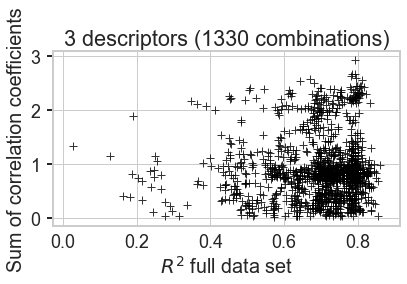

In [72]:
# Distribution of descriptor correlations, 3 descriptor combination
font = {'family': 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

fig , ax = plt.subplots()
sns.set_style("whitegrid")
ax.scatter(r_values,per,marker='+', color='black', alpha = 0.8)
ax.set_title('3 descriptors (1330 combinations)')
ax.set_ylabel('Sum of correlation coefficients')
ax.set_xlabel('$R^2$ full data set')

plt.tight_layout()
fig.savefig(picpath + 'ORR_correlation_coeff_distribution_3_descriptors.pdf')
plt.show()

How does the mean absolute error and the coefficient of determination (R2) look like for the best fits? The mean absolute error is below 0.3 eV for fits with the highest R2 scores. The LOOV R2 scores are slightly worse than those using the full data set which reflects the dataset size in this case (which is relatively small). 

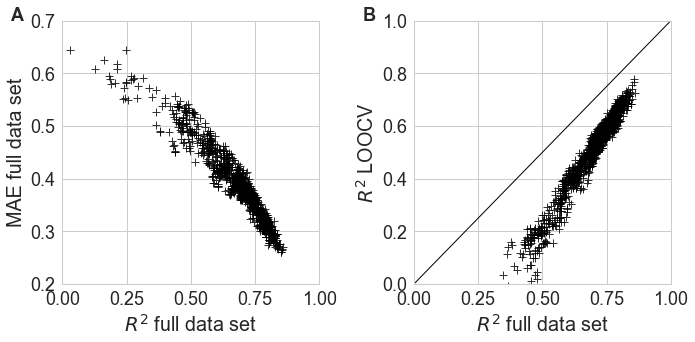

In [73]:
# Correlation between R2 and cv R2
fig, ((ax1, ax2)) = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
sns.set_style("whitegrid")

ax1.scatter(r_values, all_mae, marker='+', color='black', alpha = 0.8)
ax1.set_ylim(0.2,0.7)
ax1.set_xlim(0,1)
ax1.text(-0.2,0.7,'A', weight='bold')
ax1.set_ylabel('MAE full data set')
ax1.set_xlabel('$R^2$ full data set')

ax2.plot([0,1], [0,1], color='black', lw=1.)
ax2.scatter(r_values, r2_cv, marker='+', color='black', alpha = 0.8)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.text(-0.2,1,'B', weight='bold')
ax2.set_ylabel(r'$R^2$ LOOCV')
ax2.set_xlabel('$R^2$ full data set')

plt.tight_layout()
fig.savefig(picpath + 'ORR_R2_vs_LOOCV.pdf')
plt.show()


We chose the descriptor combination that ranks on place 3 in the ranking above, because the feature correlation amongst these features is good and these features can be computed (or looked up) easily. 

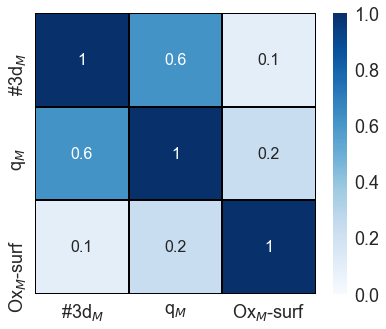

In [74]:
# Pearson correlation of 3 coefficients
descriptor_bucket = ['Z_val_bulk', 'q_M', 'active_site_oxidation_state']
train = df[descriptor_bucket]
xlist = [r'#3d$_{M}$',  r'q$_{M}$', r'Ox$_{M}$-surf']

corr = train.corr(method='pearson')**2
corr.columns = corr.columns.str.replace('_', ' ')
corr.index = corr.index.str.replace('_', ' ')
corr = corr.abs()

fig = plt.figure(figsize=(6, 5))
sns.set(font_scale=1.8)
sns.heatmap(corr, cmap="Blues", square=True, vmin=0, vmax=1, 
            linecolor='black', linewidths=0.9, annot=True, fmt='.0g',
            xticklabels = xlist, yticklabels=xlist, annot_kws={'size': 16})

plt.tight_layout()
fig_name = picpath + 'ORR_small_set_3_features.pdf'                                                                                                                                                        
fig.savefig(fig_name)
plt.show()


Let us have a closer look at the linear regression fit using our selection of 3 features by plotting a parity plot, using the colors indicated in our dictionary for easy identification.

Linear regression coefficients: 

Z_val_bulk: 0.49
q_M: 2.04
active_site_oxidation_state: 0.56
Intercept: -5.93


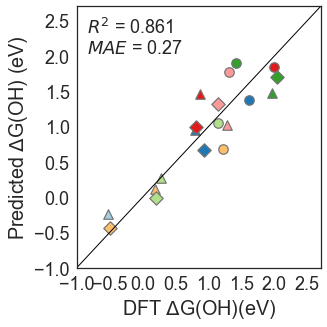

In [75]:
# PARITY PLOT 3 DESCRIPTORS
# Features
X_best = df[descriptor_bucket]

# Targets
target_values = list(df.filter(regex='ORR').columns)
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'

y = targets[target_name]

# Linear regression
clf = linear_model.LinearRegression()
clf.fit(X_best, y)
r_value = clf.score(X_best, y)
y_hat = clf.predict(X_best)

print('Linear regression coefficients: \n')
for i in range(3):
    print(list(X_best)[i]+': '+str(round(clf.coef_[i],2)))
print('Intercept: '+str(round(clf.intercept_,2)))

res = y_hat - y
mae = np.mean(np.abs(res))


# Parity plot
sns.set_style('white')
fig , ax = plt.subplots(figsize=(5, 5))

msg =  '$R^2$ = ' + str(round(r_value, 3)) + '\n'+'$MAE$ = ' + str(round(mae,3))
                                       
axmin = -1
axmax = 2.7
ax.plot([axmin,axmax], [axmin,axmax], color='black', lw=1.)

for index, row in df.iterrows():
    key1 = int(row['metal_atomic_number'])
    key2 = int(row['n_H_atoms'])
    style_list=mdict[key1][key2]   
    plt.scatter(y[index], y_hat[index], marker=style_list[8], color=style_list[9], 
                edgecolors=tcolor, label=style_list[1], s = 90.,
                linewidth='1.2')

plt.xlabel(r'DFT $\Delta$G(OH)(eV)')
plt.ylabel(r'Predicted $\Delta$G(OH) (eV)')
plt.text(axmin*0.95+0.1, axmax*0.75, msg, fontsize=18)
sns.set_style('white')
plt.xlim((axmin, axmax))
plt.ylim((axmin, axmax))
plt.xticks(np.arange(axmin, axmax,0.5))
plt.yticks(np.arange(axmin, axmax,0.5))
plt.tight_layout()
fig_name = picpath + 'ORR_parity_small_set_OH_descriptor.pdf'    
fig.savefig(fig_name)
plt.show()

Linear regression coefficients: 

Z_val_bulk: 0.34
active_site_oxidation_state: 0.7
Intercept: -2.51
R2 : 0.778


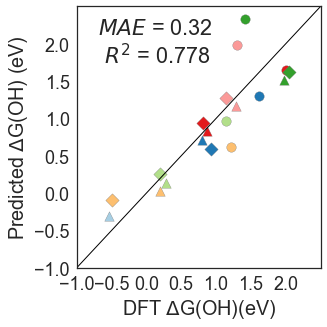

In [76]:
# 2 Descriptors Linear regression.

# Features
descriptor_bucket = ['Z_val_bulk', 'active_site_oxidation_state']
X_best = df[descriptor_bucket]

# Targets
target_values = list(df.filter(regex='ORR').columns)
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'

y = targets[target_name]
# print('>>> Target: '+target_name+'; Target shape: '+str(y.shape))

# Linear regression
clf = linear_model.LinearRegression()
clf.fit(X_best, y)
r_value = clf.score(X_best, y)
y_hat = clf.predict(X_best)

print('Linear regression coefficients: \n')
for i in range(2):
    print(list(X_best)[i]+': '+str(round(clf.coef_[i],2)))
print('Intercept: '+str(round(clf.intercept_,2)))
print('R2 : '+str(round(r_value, 3)))

res = y_hat - y
mae = np.mean(np.abs(res))

# Parity plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)

msg = "$MAE$ = " + str(round(mae,3)) + '\n $R^2$ = ' + str(round(r_value, 3))
axmin = -1.
axmax = 2.5

plt.plot([axmin,axmax], [axmin,axmax], color='black', lw=1.)

for index, row in df.iterrows():
    key1 = int(row['metal_atomic_number'])
    key2 = int(row['n_H_atoms'])
    style_list=mdict[key1][key2]   
    plt.scatter(y[index], y_hat[index], marker=style_list[8], color=style_list[9], 
                    edgecolors=tcolor, label=style_list[1], s = 90.)

plt.gcf().subplots_adjust(bottom=0.18, left=0.18)
plt.xlabel(r'DFT $\Delta$G(OH)(eV)')
plt.ylabel(r'Predicted $\Delta$G(OH) (eV)')
plt.text(axmin*0.8+0.1, axmax*0.7, msg)

plt.xlim((axmin, axmax))
plt.ylim((axmin, axmax))
plt.xticks(np.arange(axmin, axmax,0.5))
plt.yticks(np.arange(axmin, axmax,0.5))
plt.tight_layout()
fig_name = outpath + 'ORR_parity_small_set.pdf'    
fig.savefig(fig_name)
plt.show()


Linear regression coefficients: 

Z_val_bulk: 0.25
Intercept: -0.196
R2 : 0.353


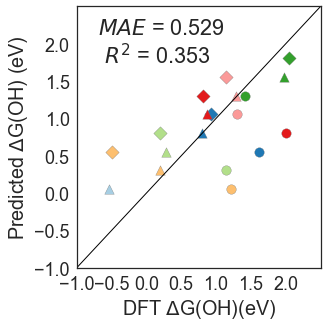

In [77]:
# 1 Descriptor Linear regression.

# Features
descriptor_bucket = ['Z_val_bulk']
X_best = df[descriptor_bucket]

# Targets
target_values = list(df.filter(regex='ORR').columns)
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'

y = targets[target_name]
# print('>>> Target: '+target_name+'; Target shape: '+str(y.shape))

# Linear regression
clf = linear_model.LinearRegression()
clf.fit(X_best, y)
r_value = clf.score(X_best, y)
y_hat = clf.predict(X_best)

print('Linear regression coefficients: \n')
for i in range(1):
    print(list(X_best)[i]+': '+str(round(clf.coef_[i],3)))
print('Intercept: '+str(round(clf.intercept_,3)))
print('R2 : '+str(round(r_value, 3)))

res = y_hat - y
mae = np.mean(np.abs(res))

# Parity plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)

msg = "$MAE$ = " + str(round(mae,3)) + '\n $R^2$ = ' + str(round(r_value, 3))
axmin = -1.
axmax = 2.5

plt.plot([axmin,axmax], [axmin,axmax], color='black', lw=1.)

for index, row in df.iterrows():
    key1 = int(row['metal_atomic_number'])
    key2 = int(row['n_H_atoms'])
    style_list=mdict[key1][key2]   
    plt.scatter(y[index], y_hat[index], marker=style_list[8], color=style_list[9], 
                    edgecolors=tcolor, label=style_list[1], s = 90.)

plt.gcf().subplots_adjust(bottom=0.18, left=0.18)
plt.xlabel(r'DFT $\Delta$G(OH)(eV)')
plt.ylabel(r'Predicted $\Delta$G(OH) (eV)')
plt.text(axmin*0.8+0.1, axmax*0.7, msg)

plt.xlim((axmin, axmax))
plt.ylim((axmin, axmax))
plt.xticks(np.arange(axmin, axmax,0.5))
plt.yticks(np.arange(axmin, axmax,0.5))
plt.tight_layout()
fig_name = outpath + 'ORR_parity_small_set.pdf'    
fig.savefig(fig_name)
plt.show()



# Statistical significance test.
By trying out many feature combinations, we could in principle get good results by mere chance. To make sure this is not the case, we perform a simplified hypothesis test: What is the probability that we get R2-values as high as we observe them by mere chance?

In [79]:
# Randomize targets to get null distribution of R2 values
all_results = []

for i in range(100):
    # Targets small set
    target_values = list(df.filter(regex='ORR').columns)
    targets = df[target_values]
    targets = targets.astype('float64')
    targets = targets.sample(frac=1).reset_index(drop=True)
    target_name = 'ORR_dG_OH'
    
    y = targets[target_name]
    
    feature_dim = 3
    results = []
    for i, combo in enumerate(unique_set(features,feature_dim), 1):
        descriptor_combination = list(combo)
        X_combination = df[descriptor_combination]
    
        # Descriptor correlations
        correlations = []
        for j, combo2 in enumerate(unique_set(descriptor_combination), 1):
            des_pairs = list(combo2)
            row = features.index(des_pairs[0])
            col = features.index(des_pairs[1])
            correlations.append(pearson_corr_matrix[row, col])
        corr_sum = sum(correlations)
        descriptor_combination.append(round(corr_sum,2))
        
        # Linear regression
        clf = linear_model.LinearRegression()
        clf.fit(X_combination, y)
        r_value = round(clf.score(X_combination, y),5)
        descriptor_combination.append(r_value)
    
        y_hat = clf.predict(X_combination)
        res = y_hat - y
        mae = round(np.mean(np.abs(res)),3)
        descriptor_combination.append(mae)
        results.append(descriptor_combination)
    
    # rank descriptor combinations
    results_sorted = sorted(results, key = lambda x: x[feature_dim + 1])
    per = np.asarray([x[feature_dim] for x in results_sorted])
    r_values_rnd = np.asarray([x[feature_dim + 1] for x in results_sorted])
    all_results.append(r_values_rnd)

Instead of calculating the z-value, we inspect the distribution visually.
The grey bars show the distribution of R2-values with randomized tagets, accumulated over hundred trials, see code above.
The white bars are the non-randomized data points, giving much higher R2-scores.


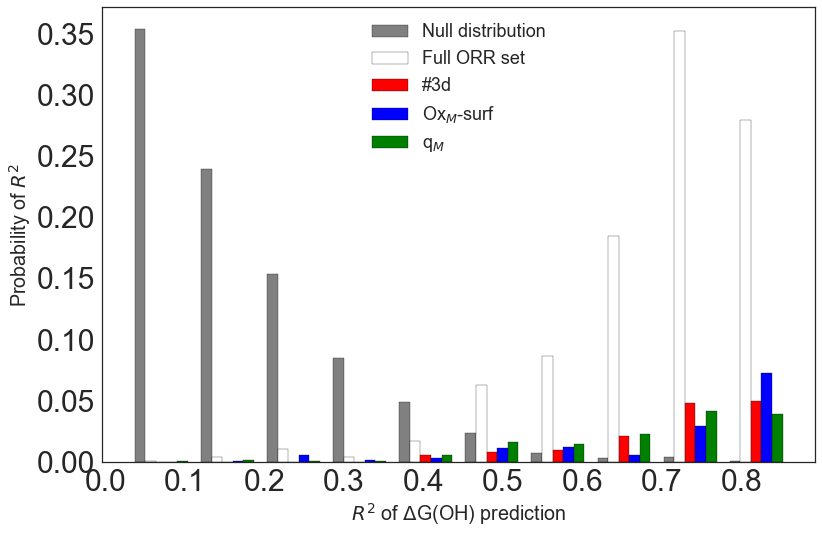

Mean of R2-values: 0.69


In [80]:
# Histogram of R2 score with null distribution
fig = plt.figure(figsize=(12, 8))
sns.set_style('white')
font = {'size': 26}
plt.rc('font', **font)

all_results_new = [item for sublist in all_results for item in sublist]
all_results_new = np.array(all_results_new)
weights1 = np.full(r_values.shape[0],1/len(r_values))
weights2 = weights1[0:r_values_z.shape[0]]
weights3 = weights1[0:r_values_ox.shape[0]]
weights4 = weights1[0:r_values_qO.shape[0]]
weights5 = np.full(all_results_new.shape[0],1/len(all_results_new))

hist, bin_edges = np.histogram(r_values, density = False, weights=weights1, bins=10)
plt.hist([all_results_new, r_values, r_values_z, r_values_ox, r_values_qO], bins=bin_edges, 
         color= ['grey', 'white', 'red', 'blue', 'green'], 
         weights = [weights5, weights1, weights2, weights3, weights4],
         label=['Null distribution', 'Full ORR set', '#3d', 'Ox$_{M}$-surf', 'q$_{M}$'], edgecolor='black')

plt.legend()
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel(r'$R^2$ of $\Delta$G(OH) prediction')
plt.ylabel(r'Probability of $R^2$')
plt.tight_layout()
plt.show()

# Print some interesting statistic
print('Mean of R2-values: '+ str(round(np.mean(r_values),2)))

How much predicitve power do we loose by not using 4 descriptors? 

In [81]:
# Targets
target_values = list(df.filter(regex='ORR').columns)
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'
y = targets[target_name]

feature_dim = 4
results = []
for i, combo in enumerate(unique_set(features,feature_dim), 1):
    descriptor_combination = list(combo)
    X_combination = df[descriptor_combination]

    # Descriptor correlations
    correlations = []
    for j, combo2 in enumerate(unique_set(descriptor_combination), 1):
        des_pairs = list(combo2)
        row = features.index(des_pairs[0])
        col = features.index(des_pairs[1])
        correlations.append(pearson_corr_matrix[row, col])
    corr_sum = sum(correlations)
    descriptor_combination.append(round(corr_sum,2))
    
    # Linear regression
    clf = linear_model.LinearRegression()
    clf.fit(X_combination, y)
    r_value = round(clf.score(X_combination, y),5)
    descriptor_combination.append(r_value)

    y_hat = clf.predict(X_combination)
    res = y_hat - y
    mae = round(np.mean(np.abs(res)),3)
    descriptor_combination.append(mae)
    
    results.append(descriptor_combination)

# rank descriptor combinations
results_sorted = sorted(results, key = lambda x: x[feature_dim + 1])
per = np.asarray([x[feature_dim] for x in results_sorted])
r_values = np.asarray([x[feature_dim + 1] for x in results_sorted])

print('Number of combinations considered: '+str(len(results_sorted)))
print('3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE'+'\n')
for i, entry in enumerate(results_sorted):
    result = results_sorted[-(i+1)]
    if i <=5:
        print(str(i+1) +': '+ str(result))

Number of combinations considered: 5985
3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE

1: ['Z_val_bulk', 'q_M', 'active_site_oxidation_state', '1st', 1.26, 0.88833, 0.231]
2: ['Z_val_bulk', 'q_M', 'active_site_oxidation_state', '5th', 1.05, 0.88568, 0.238]
3: ['Z_val_bulk', 'q_M', 'active_site_oxidation_state', '3rd', 1.48, 0.87943, 0.241]
4: ['Z_val_atom', 'q_M', 'bandgap', '5th', 0.4, 0.87819, 0.231]
5: ['Z_val_bulk', 'q_M', 'q_O', '5th', 0.31, 0.87424, 0.252]
6: ['q_M', 'n_d_el_active', 'active_site_oxidation_state', '5th', 0.93, 0.8735, 0.248]


The resulting R2-values aren't that much better than using 3 descriptors (R2-values above 0.83). What about the descriptor correlation?

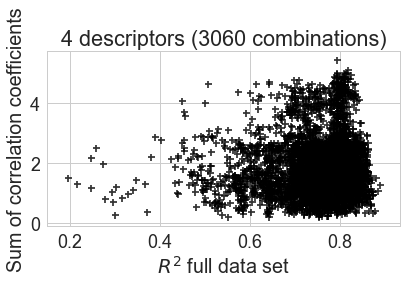

In [82]:
font = {'family': 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
sns.set_style("whitegrid")
fig , ax = plt.subplots()

ax.scatter(r_values,per,marker='+', color='black', alpha = 0.8)
ax.set_title('4 descriptors (3060 combinations)')
ax.set_ylabel('Sum of correlation coefficients')
ax.set_xlabel('$R^2$ full data set')

plt.tight_layout()
fig.savefig(outpath + 'correlation_coeff_3_descriptors.png')
plt.show()

In fact, the descriptor correlation goes up and is pretty high even for the best performing models. Using 4 descriptors, we may overfit. 
How much worse do we perform with only 2 descriptors instead of 3?:

In [84]:
# Targets 
target_values = list(df.filter(regex='ORR').columns)
targets = df[target_values]
targets = targets.astype('float64')
target_name = 'ORR_dG_OH'
y = targets[target_name]

feature_dim = 2
results = []
for i, combo in enumerate(unique_set(features,feature_dim), 1):
    descriptor_combination = list(combo)
    X_combination = df[descriptor_combination]

    # Descriptor correlations
    correlations = []
    for j, combo2 in enumerate(unique_set(descriptor_combination), 1):
        des_pairs = list(combo2)
        row = features.index(des_pairs[0])
        col = features.index(des_pairs[1])
        correlations.append(pearson_corr_matrix[row, col])
    corr_sum = sum(correlations)
    descriptor_combination.append(round(corr_sum,2))
    
    # Linear regression
    clf = linear_model.LinearRegression()
    clf.fit(X_combination, y)
    r_value = round(clf.score(X_combination, y),5)
    descriptor_combination.append(r_value)

    y_hat = clf.predict(X_combination)
    res = y_hat - y
    mae = round(np.mean(np.abs(res)),3)
    descriptor_combination.append(mae)
    
    results.append(descriptor_combination)

# rank descriptor combinations
results_sorted = sorted(results, key = lambda x: x[feature_dim + 1])
per = np.asarray([x[feature_dim] for x in results_sorted])
r_values = np.asarray([x[feature_dim + 1] for x in results_sorted])

print('Number of combinations considered: '+str(len(results_sorted)))
print('3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE'+'\n')
for i, entry in enumerate(results_sorted):
    result = results_sorted[-(i+1)]
    if i <=5:
        print(str(i+1) +': '+ str(result))


Number of combinations considered: 210
3 Descriptors | Sum of Descriptor Correlation  | R2 | MAE

1: ['Z_val_atom', 'q_M', 0.01, 0.82474, 0.29]
2: ['active_site_oxidation_state', 'c6', 0.01, 0.80529, 0.304]
3: ['d_MO', '4th', 0.02, 0.7947, 0.327]
4: ['bulk_metal_oxidation_state', 'c6', 0.89, 0.79374, 0.313]
5: ['n_d_el_active', 'active_site_oxidation_state', 0.12, 0.79157, 0.297]
6: ['Z_val_atom', 'active_site_oxidation_state', 0.1, 0.79157, 0.297]


Two descriptors perform worse, although not that much worse.

# Summary
We analyzed atomic, bulk and surface features to predict the adsorption energy of OH molecules on active centers. The targets being energetics calculated via density functional theory. We find that with 2-3 descritors, we get quite accurate predicitons of the OH adsorption energies.